## ML models

In [1]:
import pandas as pd

### Load data

In [2]:
df_train = pd.read_csv("train_data.csv", index_col=0)
df_test = pd.read_csv("test_data.csv", index_col=0)

In [3]:
def load_data():
    X_train = df_train.drop("label", axis=1)
    y_train = df_train["label"]

    X_test = df_test.drop("label", axis=1)
    y_test = df_test["label"]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data()

In [4]:
print(X_train.shape, X_test.shape)

(2103, 63) (902, 63)


### Decision trees

In [12]:
from sklearn import tree

In [63]:
DTC = tree.DecisionTreeClassifier(
    criterion="entropy",
    max_depth=8,
    min_samples_split=10,
    max_features="auto",
    random_state=100
)

In [64]:
DTC.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [65]:
train_score = DTC.score(X_train, y_train)
test_score = DTC.score(X_test, y_test)

print("Training accuracy: {0:5.2f}%.\
      \nTesting accuracy: {1:5.2f}%"
      .format(100*train_score, 100*test_score))

Training accuracy: 93.34%.      
Testing accuracy: 86.59%


### Radom forest

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
RFC = RandomForestClassifier(
    n_estimators=100,
    criterion="entropy",
    max_depth=5,
    min_samples_split=10,
    random_state=100,
)

In [74]:
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

In [75]:
train_score = RFC.score(X_train, y_train)
test_score = RFC.score(X_test, y_test)

print("Training accuracy: {0:5.2f}%.\
      \nTesting accuracy: {1:5.2f}%"
      .format(100*train_score, 100*test_score))

Training accuracy: 96.53%.      
Testing accuracy: 93.46%


### Gradient boosting tree

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

In [6]:
GBC = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    max_depth=2, 
    random_state=100
)

In [7]:
GBC.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=100, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [8]:
train_score = GBC.score(X_train, y_train)
test_score = GBC.score(X_test, y_test)

print("Training accuracy: {0:5.2f}%.\
      \nTesting accuracy: {1:5.2f}%"
      .format(100*train_score, 100*test_score))

Training accuracy: 99.05%.      
Testing accuracy: 95.01%


In [9]:
y_test.value_counts()

company     273
profile     255
tasks       195
benefits    179
Name: label, dtype: int64

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = ["company", "tasks", "profile", "benefits"]
y_pred_train = GBC.predict(X_train)
y_pred_test = GBC.predict(X_test)
cm_train = confusion_matrix(y_train, y_pred_train, labels=labels)
cm_test = confusion_matrix(y_test, y_pred_test, labels=labels)

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix as a heatmap.
    
    Inputs
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
    fontsize: int
        Font size for axes labels.
        
    Outputs
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", center=0, cmap=cmap, cbar_kws={"shrink": .70})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)

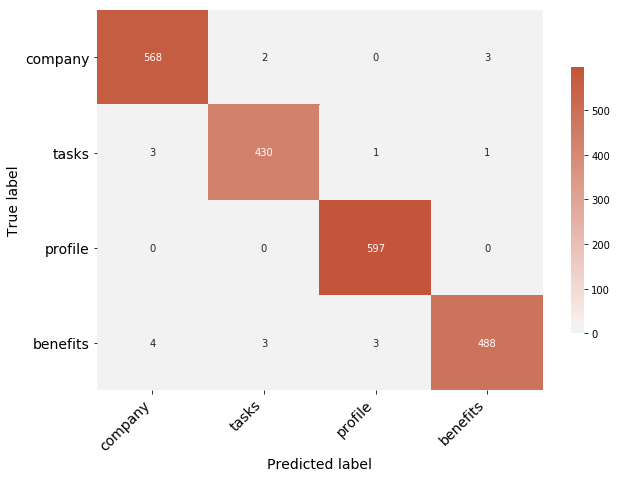

In [27]:
print_confusion_matrix(confusion_matrix=cm_train, class_names=labels)

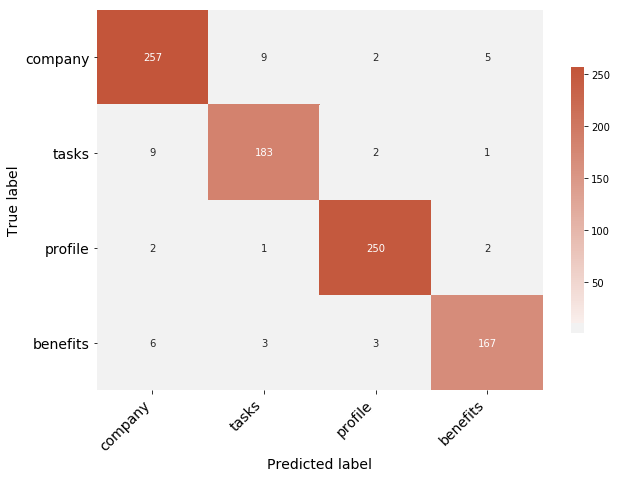

In [28]:
print_confusion_matrix(confusion_matrix=cm_test, class_names=labels)

Neural networks

In [47]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2

In [31]:
# make stats file for train data
df_stats = df_train.describe().loc[["mean", "std"],].transpose()

In [29]:
def norm(df, train_stats):
    """Normalized based on mean and std of training data
    
    input
    --------
    df : dataframe
        input features
    train_stats : dataframe
        statistics of train data, from pd.DataFrame.describe function
    
    output
    --------
    Normalized df
    """
    return (df - train_stats['mean']) / train_stats['std']

In [37]:
def make_train_data():
    """make training inputs and statistic file for selected factors. 
    
    outputs
    -------
    train_data : ndarray
        normilized factors
    train_labels : ndarray
        target label
        
    notes
    --------
    save statistics of factors, will be used to normalize the input of prediction. 
    """
    label_column = "label"
    
    df_input_pm = df_train.iloc[np.random.permutation(len(df_train))]
    features = df_input_pm.drop(label_column, axis=1)
    train_features_norm = norm(features, df_stats)
    train_label = df_input_pm[label_column]
    return train_features_norm, train_label

In [45]:
class NeuralNetworksHC():
    """NN model predict headcount for each job family
    """
    def __init__(self, learning_rate=0.001, n_epoch=3000):
        self.learning_rate = learning_rate
        self.n_epoch = n_epoch
        
    def build_model(self, X):
        """Get input varibles X and labels y

        input
        --------
        learning_rate : float
            learning rate of the learning algorithm

        output
        --------
        NN : fully connected neural networks model

        note
        --------
        Neural network with 2 hidden layers, including 32 and 32 neurons.
        mean squared error as the loss function
        mean absolute error as the metric
        """
        NN = Sequential()
        NN.add(Dense(8, activation='relu', input_dim=X.shape[1]))
        NN.add(Dense(8, activation='relu', bias_regularizer=l2(0.01)))
        NN.add(Dense(1))

        optimizer = RMSprop(self.learning_rate)

        NN.compile(loss='mean_squared_error',
                      optimizer=optimizer,
                      metrics=['mean_absolute_error'])
        return NN

    def train(self, X, y):
        """train and test model.
        
        inputs
        --------
        train_data, train_labels, test_data, test_labels
        
        outputs
        --------
        model : trained model by train_data set
        history : learning history of the model
        
        """
        
        clear_session()

        self.model = self.build_model(X)
        self.history = self.model.fit(
            X, y,
            validation_split = 0.3,
            epochs=self.n_epoch, verbose=0,
            callbacks=[PrintDot(self.n_epoch)]
        )

        return self

In [48]:
class PrintDot(Callback):
    """Customized callback function.
    """
    def __init__(self, n_epoch):
        self.n_epoch = n_epoch
        
    def on_epoch_end(self, epoch, logs):
        if epoch % (self.n_epoch/100) == 0: print('.', end='')

In [38]:
train_features, train_label = make_train_data()


In [51]:
model = NeuralNetworksHC(learning_rate=0.001, n_epoch=1000)
model.train(train_features, train_label)

W0311 17:32:56.413173 140489140602624 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


ValueError: could not convert string to float: 'profile'

In [ ]:
tf.one_hot(indices=tf.cast(train_labels, tf.int32), depth=num_classes)